# Deflection by an extended mass distribution

In this application, we implement the calculation of the deflection angle field by an extended lens. A two-dimensional map of the lens surface-density is contained the ```data``` forlder and it is called ```kappa_2.fits```. To be precise, this is the surface density divided by a constant which depends on the lens and source redshifts (we will talk about this constant in the next lectures). Let's denote this quantity as $\kappa$. Accounting for this normalization, the calulation we want to implement is 
$$
\vec\alpha(\vec x)=\frac{1}{\pi}\int\kappa(\vec x')\frac{\vec x-\vec x'}{|\vec x-\vec x'|^2}d^2 x' \;.
$$
This is a convolution, which can be written in the Fourier Space as
$$
\vec{\tilde\alpha}(\vec k)=2\pi \tilde\kappa (\vec k) \vec{\tilde K} (\vec k) 
$$
where  $\vec{\tilde{K}}(\vec{k})$ is the Fourier Transform of 
$$
\vec{K}(\vec x)=\frac{1}{\pi}\frac{\vec{x}}{|\vec{x}|^2}
$$

To implement this calculation, we use the ```numpy.fft``` module.

In [1]:
import numpy as np
import numpy.fft as fftengine

We define a class called deflector, where the deflector object is initialized throught a fits file containing the surface density map of the lens.
To deal with the fits files, we need to use the ```astropy.io.fits``` module.

The class contains some methods to 
* build the kernel $K(\vec{x})$
* compute the deflection angle map by convolving the convergence with the kernel 
* perform the so-called "zero-padding"

In [2]:
import astropy.io.fits as pyfits 


class deflector(object):
    
    # initialize the deflector using a surface density (covergence) map
    # the boolean variable pad indicates whether zero-padding is used or not
    def __init__(self,filekappa,pad=False):
        kappa,header=pyfits.getdata(filekappa,header=True)
        self.kappa=kappa
        self.nx=kappa.shape[0]
        self.ny=kappa.shape[1]
        self.pad=pad
        if (pad):
            self.kpad()
        self.kx,self.ky=self.kernel()
        
    # implement the kernel function K
    def kernel(self):
        x=np.linspace(-0.5,0.5,self.kappa.shape[0])
        y=np.linspace(-0.5,0.5,self.kappa.shape[1])
        kx,ky=np.meshgrid(x,y)
        norm=(kx**2+ky**2+1e-12)
        kx=kx/norm/np.pi
        ky=ky/norm/np.pi
        return(kx,ky)
    
    # compute the deflection angle maps by convolving
    # the surface density with the kernel function
    def angles(self):
        # FFT of the surface density and of the two components of the kernel
        kappa_ft = fftengine.fftn(self.kappa,axes=(0,1))
        kernelx_ft = fftengine.fftn(self.kx,axes=(0,1),
                                     s=self.kappa.shape)
        kernely_ft = fftengine.fftn(self.ky,axes=(0,1),
                                     s=self.kappa.shape)
        # perform the convolution in Fourier space and transform the result
        # back in real space. Note that a shift needs to be applied using 
        # fftshift
        alphax = 2.0/(self.kappa.shape[0])/(np.pi)**2*\
                fftengine.fftshift(fftengine.ifftn(2.0*\
                np.pi*kappa_ft*kernelx_ft))
        alphay = 2.0/(self.kappa.shape[0])/(np.pi)**2*\
                fftengine.fftshift(fftengine.ifftn(2.0*\
                np.pi*kappa_ft*kernely_ft))
        return(alphax.real,alphay.real)
    
    # returns the surface-density (convergence) of the deflector
    def kmap(self):
        return(self.kappa)
    
    # performs zero-padding
    def kpad(self):
        # add zeros around the original array
        def padwithzeros(vector, pad_width, iaxis, kwargs):
            vector[:pad_width[0]] = 0
            vector[-pad_width[1]:] = 0
            return vector
        # use the pad method from numpy.lib to add zeros (padwithzeros) in a
        # frame with thickness self.kappa.shape[0]
        self.kappa=np.lib.pad(self.kappa, self.kappa.shape[0], 
                              padwithzeros)
    
    # crop the maps to remove zero-padded areas and get back to the original 
    # region.
    def mapCrop(self,mappa):
        xmin=self.kappa.shape[0]/2-self.nx/2
        ymin=self.kappa.shape[1]/2-self.ny/2
        xmax=xmin+self.nx
        ymax=ymin+self.ny
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)
    
    # alternative using astropy.convolve, which can also include zero-padding
    # and many other features:
    # http://docs.astropy.org/en/stable/api/astropy.convolution.convolve_fft.html
    def angles_alternative(self):
        from astropy.convolution import convolve, convolve_fft
        angx = 2.0*np.pi*convolve_fft(self.kappa, self.kx, fft_pad=True)
        angy = 2.0*np.pi*convolve_fft(self.kappa, self.ky, fft_pad=True)
        return(angx,angy)


    def potential(self):
        # define an array of wavenumbers (two components k1,k2)
        k = np.array(np.meshgrid(fftengine.fftfreq(self.kappa.shape[0])\
                                 ,fftengine.fftfreq(self.kappa.shape[1])))
        pix=1 # pixel scale (now using pixel units)
        #Compute Laplace operator in Fourier space = -4*pi*l*l
        kk = k[0]**2 + k[1]**2
        kk[0,0] = 1.0
        #FFT of the convergence
        kappa_ft = fftengine.fftn(kappa)
        #compute the FT of the potential
        kappa_ft *= - pix**2 / (kk * (2.0*np.pi**2))
        kappa_ft[0,0] = 0.0
        potential=fftengine.ifftn(kappa_ft) #units should be rad**2
        return potential.real

We can now build a deflector and use it to compute the deflection angles employing the method ```angles```: 

/Users/massimo/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


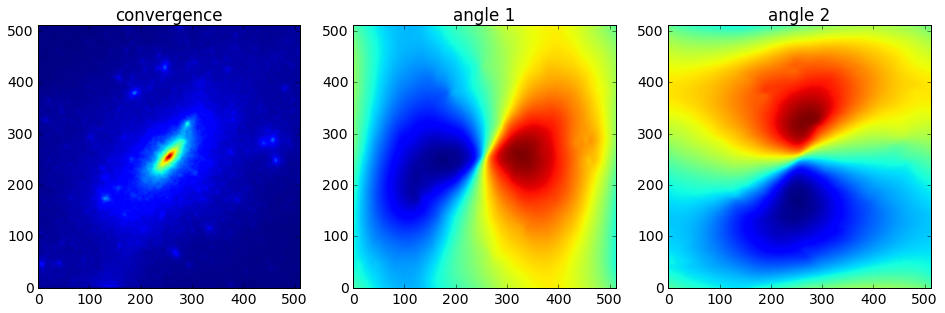

In [3]:
df=deflector('data/kappa_gl.fits')
angx_nopad,angy_nopad=df.angles()
kappa=df.kmap()

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

#plot the results
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fig,ax = plt.subplots(1,3,figsize=(16,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx_nopad,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy_nopad,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('no_padding.png')

Note that at this point we have not yet used the zero-padding trick. FFT assumes periodic boundaries conditions, meaning that the lens mass distribution is replicated outside the boundaries. Given that the region around the lens considered in this example is relatively small, we expect that the deflection angles will be biased near the borders.  
The three panels in the figure above show the maps of the convergence and of the two components of the deflection angles obtained with this setting. 

Zero-padding consists of placing zeros all around the convergence map. By doing so, we double the size of the original  map, but we expect to increase the accuracy of the calculations near the borders, beacause the periodic conditions are better reproduced in this setting. We activate zero-padding by just setting the variable ```pad=True``` when initializing the deflector. The figure below shows the zero-padded convergence map and the two new maps of the deflection angle components.  

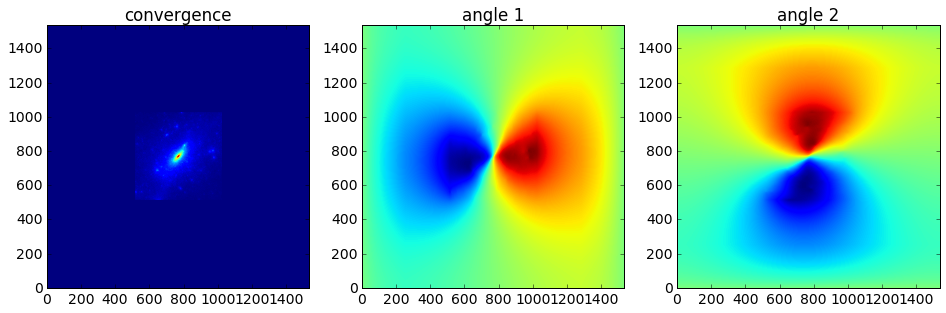

In [4]:
df=deflector('data/kappa_gl.fits',True)
angx,angy=df.angles()
kappa=df.kmap()

fig,ax = plt.subplots(1,3,figsize=(16,8))
angx,angy=df.angles()
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(angx,origin="lower")
ax[1].set_title('angle 1')
ax[2].imshow(angy,origin="lower")
ax[2].set_title('angle 2')
fig.savefig('padding.png')

We are not interested in this large area, thus we can get rid of the values outside the lens convergence map by cropping the deflection angle maps. The results are shown below and compared to the previous ones. In fact, significant differences are visible along the borders. 

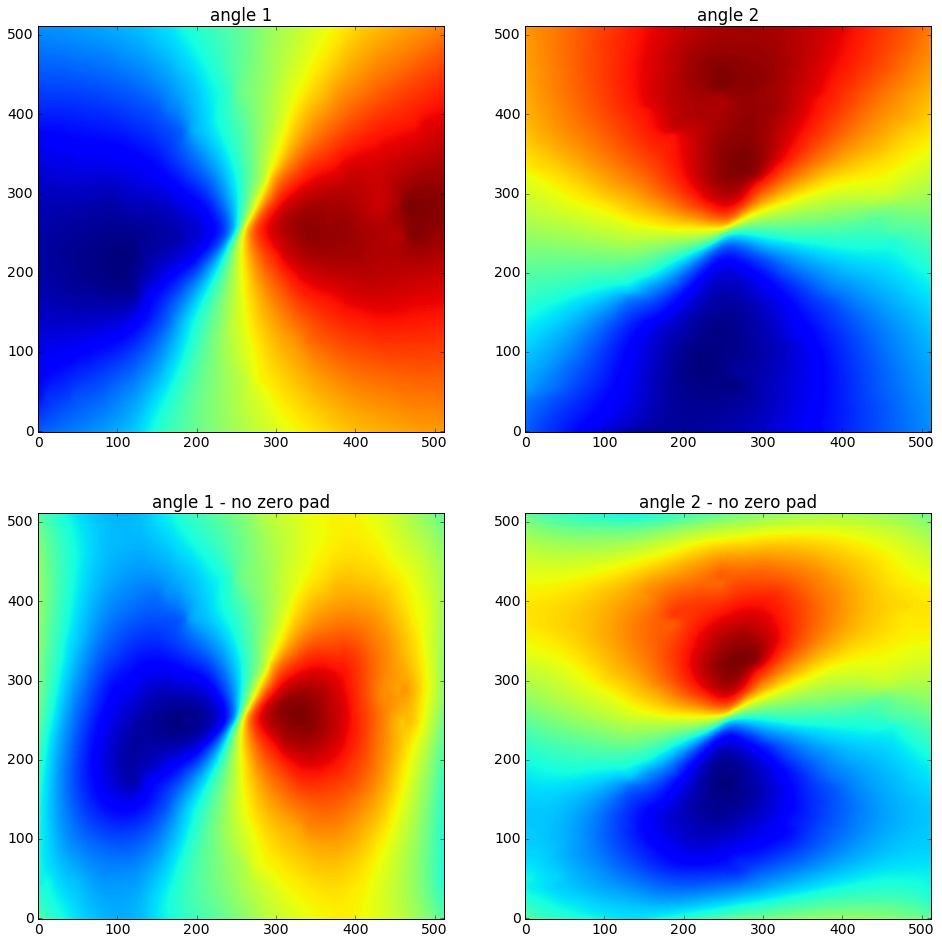

In [5]:
angx=df.mapCrop(angx)
angy=df.mapCrop(angy)

fig,ax = plt.subplots(2,2,figsize=(16,16))
ax[0,0].imshow(angx,origin="lower")
ax[0,0].set_title('angle 1')
ax[0,1].imshow(angy,origin="lower")
ax[0,1].set_title('angle 2')
ax[1,0].imshow(angx_nopad,origin="lower")
ax[1,0].set_title('angle 1 - no zero pad')
ax[1,1].imshow(angy_nopad,origin="lower")
ax[1,1].set_title('angle 2 - no zero pad')
fig.savefig('padding_cropped.png')

# Ray-tracing

In this exercise, we will implement a simple ray-tracing algorithm. In ray-tracing, we make use of the lens equation to propagate a bundle of light-rays from the observer position, through a regular grid covering the lens plane, to the source plane. For each ray passing through the position $\vec x_{ij}$, we will evaluate the deflection angle $\vec\alpha(\vec x_{ij})$ and compute the arrival position on the source plane as
$$
\vec y_{ij}=\vec x_{ij}-\vec{\alpha}(\vec x_{ij})
$$

The deflector used in this example is the same of the previous exercise. Therefore, we will use the deflection angle maps shown in the upper panels in the figure above. 

The lens equation has two components, on for each axis on the lens plane. We create a mesh, where each grid-point has two coordinates. Suppose coordinates along the $x_1$ and $x_2$ axes are represented by $n\times 1$ matrices $|x_1^{i}|$ and $|x_2^i|$, with $i\in [1,n]$.
We can apply the lens equation and find that
\begin{equation*}
\begin{vmatrix}
y_1^{1,1} & .. & y_1^{1,n}  \\
: & & : \\
y_1^{n,1} & .. & y_1^{n,n}  
\end{vmatrix}
=
\begin{vmatrix}
x_1^1 \\
:\\
x_1^n 
\end{vmatrix}
-
\begin{vmatrix}
\alpha_1^{1,1} & .. & \alpha_1^{1,n}  \\
: & & : \\
\alpha_1^{n,1} & .. & \alpha_1^{n,n}  
\end{vmatrix}
=
\begin{vmatrix}
x_1^1-\alpha_1^{1,1} & .. & x_1^1-\alpha_1^{1,n}  \\
: & & : \\
x_1^n-\alpha_1^{n,1} & .. & x_1^n-\alpha_1^{n,n}  
\end{vmatrix}
\end{equation*}
In the second term of the last equation, we add  $|x_1^i|$ to each column of the matrix $-|\alpha_1^{ij}|$.

Computing the coordinates $|y_2^{ij}|$ involves few more steps. Again, using the lens equation, we obtain:
\begin{equation*}
\begin{vmatrix}
y_2^{1,1} & .. & y_2^{n,1}  \\
: & & : \\
y_2^{1,n} & .. & y_2^{n,n}  
\end{vmatrix}
=
\begin{vmatrix}
x_2^1 \\
:\\
x_2^n 
\end{vmatrix}
-
\begin{vmatrix}
\alpha_2^{1,1} & .. & \alpha_2^{n,1}  \\
: & & : \\
\alpha_2^{1,n} & .. & \alpha_2^{n,n}  
\end{vmatrix}
=
\begin{vmatrix}
x_2^1-\alpha_2^{1,1} & .. & x_2^1-\alpha_2^{n,1}  \\
: & & : \\
x_2^n-\alpha_2^{1,n} & .. & x_2^n-\alpha_2^{n,n}  
\end{vmatrix}
\end{equation*}
This equation implements the column-wise addition of $|x_2^i|$ to  $-|\alpha_2^{ji}|=|\alpha_2^{ij}|^T$, where $T$ indicates the transposed matrix. The result is $|y_2^{ji}|=|y_2^{ij}|^T$. 

These equations can be implemented in python very easily:

In [ ]:
npix=angx.shape[0]
x1=np.linspace(0.0,1.0,npix)*(npix-1) # define x1 coordinates
x2=np.linspace(0.0,1.0,npix)*(npix-1) # define x2 coordinates
x1_,x2_=np.meshgrid(x1,x2) # lens plane mesh
# ray-tracing:
y1=(x1-angx) # y1 coordinates on the source plane
y2=np.transpose(x2-np.transpose(angy)) # y2 coordinates on the source plane

#plot the results
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.plot(np.reshape(x1_,x1_.size),np.reshape(x2_,x2_.size),',',color='blue')
ax.plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),',',color='red')
ax.set_xlim([0,npix-1])
ax.set_ylim([0,npix-1])


Let's try to downsample the grid by a factor of 16 on both sides. In this case, we have to interpolate the maps of the deflection angles at a reduced number of positions compared to the original map:

In [ ]:
ndown=16
x1=np.linspace(0.0,1.0,npix/ndown)*(npix-1) # dowsampled x1,x2 coordinates
x2=np.linspace(0.0,1.0,npix/ndown)*(npix-1) # 
x1_,x2_=np.meshgrid(x1,x2) # downsampled grid
# now we need to interpolate the defl. angle maps at (x1_,x2_)
# we can use the method map_coordinates from scipy.ndimage
from scipy.ndimage import map_coordinates
# first, we need to reshape x1_ and x2_:
x=np.reshape(x1_,x1_.size)
y=np.reshape(x2_,x2_.size)
# then we interpolate:
angx_=map_coordinates(angx,[[y],[x]],order=1)
angy_=map_coordinates(angy,[[y],[x]],order=1)
# now we reshape the angles back to a mesh
angx_=angx_.reshape((npix/ndown,npix/ndown))
angy_=angy_.reshape((npix/ndown,npix/ndown))
# finally we ray-trace:
y1=(x1-angx_)
y2=np.transpose(x2-np.transpose(angy_))
#plot the results
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}
import matplotlib
matplotlib.rc('font', **font)

fig,ax=plt.subplots(1,2,figsize=(17,8))
ax[0].plot(np.reshape(xray_,xray_.size),np.reshape(yray_,yray_.size),'o',color='blue',markersize=3.5)
ax[1].plot(np.reshape(y1,y1.size),np.reshape(y2,y2.size),'o',color='red',markersize=3.5)
ax[0].set_title('Lens plane')
ax[1].set_title('Source plane')
ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('$x_2$')
ax[1].set_xlabel('$y_1$')
ax[1].set_ylabel('$y_2$')
for i in [0,1]:
    ax[i].set_xlim([0,npix-1])
    ax[i].set_ylim([0,npix-1])

fig.savefig('raytracing.png')

# Lensing potential

Deriving the lensing potential from the lens convergence map requires to solve the Poisson equation in two dimensions:
$$
\kappa(\vec x) = \frac{1}{2}\triangle \Psi
$$
This can be done numerically by means of Fast-Fourier-Transform. 

The Fourier transform of the Laplace operator is
$$
\tilde{\triangle}(\vec k)=-4\pi^2 k^2
$$
where $k^2=k_1^2+k_2^2$.
Therefore, in Fourier space, the Poisson equation reads
$$
-4\pi^2k^2\tilde\Psi(\vec k)=2\tilde\kappa(\vec k) \;.
$$
The Fourier transform of the lensing potential is then
$$
\tilde\Psi(\vec k)=-\frac{\tilde\kappa(\vec k)}{2\pi^2k^2} \;.
$$

In [ ]:
pot=df.potential()
kappa=df.mapCrop(kappa)
pot=df.mapCrop(pot)

fig,ax = plt.subplots(1,2,figsize=(17,8))
ax[0].imshow(kappa,origin="lower")
ax[0].set_title('convergence')
ax[1].imshow(pot,origin="lower")
ax[1].set_title('potential')
fig.savefig('potential.png')